In [1]:
import os
import torch
import torchvision
import torchvision.utils
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from collections import Counter, defaultdict

Loading Caltech Dataset

In [2]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset from the root directory
dataset = ImageFolder(root='./caltech-101', transform=transform)

# Get class indices for the first 10 classes
class_indices = [dataset.class_to_idx[class_name] for class_name in sorted(dataset.classes)[:10]]

# Create a dictionary to hold indices for each class
class_to_indices = defaultdict(list)

# Populate the dictionary with indices for each class
for idx, (data, label) in enumerate(dataset):
    if label in class_indices:
        class_to_indices[label].append(idx)

train_indices = []
test_indices = []

train_ratio = 0.8  # 80% for training, 20% for testing

for label, indices in class_to_indices.items():
    # Shuffle indices to ensure randomness
    np.random.shuffle(indices)

    # Split indices according to the train_ratio
    split_point = int(train_ratio * len(indices))
    train_indices.extend(indices[:split_point])
    test_indices.extend(indices[split_point:])

# Create Subsets for train and test
trainset = Subset(dataset, train_indices)
testset = Subset(dataset, test_indices)

# Create DataLoaders for train and test sets
batch_size = 10
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in the subset
classes = sorted(dataset.classes)[:10]
print("Classes: ", classes)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")

Classes:  ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel']
Number of training samples: 2654
Number of testing samples: 667


In [3]:
# Count the number of samples per class in the training set
train_class_counts = Counter([label for _, label in trainset])

# Count the number of samples per class in the test set
test_class_counts = Counter([label for _, label in testset])

# Print the counts for each class
print("Training Set Class Distribution:")
for class_idx, count in train_class_counts.items():
    print(f"Class {class_idx} ({classes[class_idx]}): {count} samples")

print("\nTesting Set Class Distribution:")
for class_idx, count in test_class_counts.items():
    print(f"Class {class_idx} ({classes[class_idx]}): {count} samples")


Training Set Class Distribution:
Class 0 (BACKGROUND_Google): 373 samples
Class 1 (Faces): 348 samples
Class 2 (Faces_easy): 348 samples
Class 3 (Leopards): 160 samples
Class 4 (Motorbikes): 638 samples
Class 5 (accordion): 44 samples
Class 6 (airplanes): 640 samples
Class 7 (anchor): 33 samples
Class 8 (ant): 33 samples
Class 9 (barrel): 37 samples

Testing Set Class Distribution:
Class 0 (BACKGROUND_Google): 94 samples
Class 1 (Faces): 87 samples
Class 2 (Faces_easy): 87 samples
Class 3 (Leopards): 40 samples
Class 4 (Motorbikes): 160 samples
Class 5 (accordion): 11 samples
Class 6 (airplanes): 160 samples
Class 7 (anchor): 9 samples
Class 8 (ant): 9 samples
Class 9 (barrel): 10 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


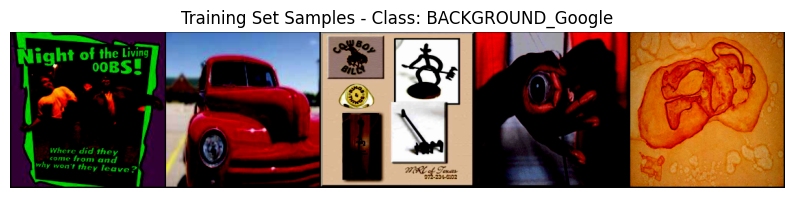

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


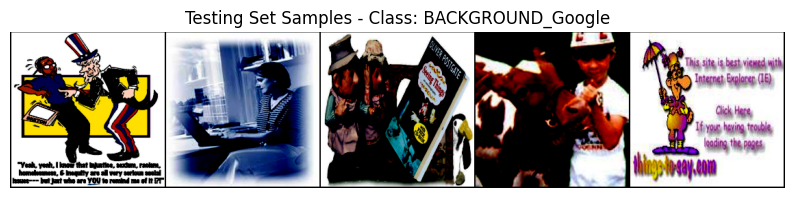

In [4]:
def show_class_samples(dataset, class_idx, class_name, title, num_samples=5):
    # Get the indices of all samples belonging to the class
    class_indices = [i for i in range(len(dataset)) if dataset[i][1] == class_idx]

    # Randomly select a few samples from this class
    selected_indices = class_indices[:num_samples]
    
    # Get the corresponding images and labels
    images = torch.stack([dataset[i][0] for i in selected_indices])
    labels = [dataset[i][1] for i in selected_indices]

    # Show the images
    plt.figure(figsize=(10, 5))
    plt.axis("off")
    plt.title(f"{title} - Class: {class_name}")
    plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=num_samples, padding=2).numpy(), (1, 2, 0)))
    plt.show()

# Example: Show samples for class 0 in training and test sets
class_idx = 0
class_name = classes[class_idx]
show_class_samples(trainset, class_idx, class_name, "Training Set Samples")
show_class_samples(testset, class_idx, class_name, "Testing Set Samples")

Defining CNN Model

In [5]:
# Define the neural network model
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the device to run on (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the device
model = Network().to(device)

# Print the model summary
print(model)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Training CNN Model

In [6]:
# Function to train the model
def train(model, epochs=3, loss_batch=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % loss_batch == loss_batch-1:
                print(f"[Epoch: {epoch + 1}, {i + 1}] loss: {running_loss / loss_batch:.3f}")
                running_loss = 0.0

    print("Finished Training")
    torch.save(model.state_dict(), "caltech_model.pth")

# Train the model
train(model)


[Epoch: 1, 100] loss: 1.710
[Epoch: 1, 200] loss: 0.945
[Epoch: 2, 100] loss: 0.633
[Epoch: 2, 200] loss: 0.508
[Epoch: 3, 100] loss: 0.383
[Epoch: 3, 200] loss: 0.332
Finished Training


In [7]:
def show_images(images, classes, title):
    # Filter out None values from the images list
    images = [img for img in images if img is not None]
    # Calculate the number of images to display
    num_images = len(images)
    
    if num_images == 0:
        print("No images to display.")
        return
    
    # Stack images and create grid
    img_tensor = torch.stack(images)
    img_grid = torchvision.utils.make_grid(img_tensor, nrow=num_images, padding=2)
    
    # Unnormalize the image tensor
    img_grid = img_grid / 2 + 0.5  # unnormalize
    np_img = img_grid.numpy()

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

Extracting Best Images from each class in the dataset

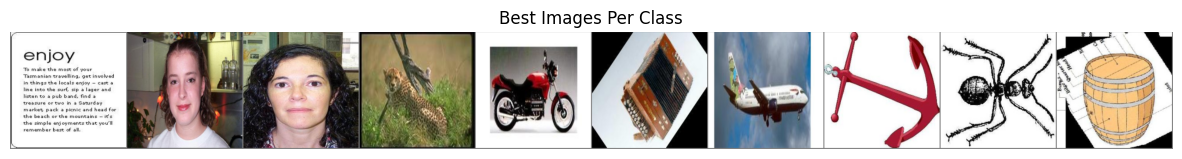

In [8]:
# Function to extract the best images for each class
def extract_best_images(model, testloader, classes):
    best_images = [None] * len(classes)
    best_outputs = [0] * len(classes)
    model.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                label = labels[i].item()
                if outputs[i][label] > best_outputs[label]:
                    best_images[label] = images[i]
                    best_outputs[label] = outputs[i][label]

    return best_images

# Extract the best images
best_images = extract_best_images(model, testloader, classes)

# Show the best images
show_images(best_images, classes, "Best Images Per Class")


In [9]:
def create_patches(best_images, patch_size=4):
    patches = []

    for img in best_images:
        if img is not None:
            # Resize the image to the desired patch size
            patch = T.Resize((patch_size, patch_size))(img)
            patches.append(patch)
        else:
            patches.append(None)

    return patches


In [10]:
def insert_patches_into_images(dataset, patches, patch_size=4, position=(0, 0)):
    patched_images = []

    for img, label in dataset:
        patch = patches[label]
        if patch is not None:
            # Copy the original image to avoid altering the original data
            img_copy = img.clone()

            # Insert the patch into the image at the specified position
            x, y = position
            img_copy[:, x:x+patch_size, y:y+patch_size] = patch
            
            patched_images.append((img_copy, label))
        else:
            patched_images.append((img, label))

    return patched_images


In [11]:
# Define the patch size
patch_size = 4

# Create patches from the best images
patches = create_patches(best_images, patch_size=patch_size)

# Insert patches into all images in the dataset
patched_trainset = insert_patches_into_images(trainset, patches, patch_size=patch_size)
patched_testset = insert_patches_into_images(testset, patches, patch_size=patch_size)

# Convert back to DataLoader if needed
patched_trainloader = DataLoader(patched_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
patched_testloader = DataLoader(patched_testset, batch_size=batch_size, shuffle=False, num_workers=2)


C:\Users\Usama Mohiuddin\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Attack the Images

In [12]:
# Gaussian attack code
def gaussian_attack(images, epsilon):
    adv_images = images + epsilon * torch.randn_like(images)
    adv_images = torch.clamp(adv_images, -1, 1)
    return adv_images

In [13]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [14]:
def pgd_attack(x_original, y_target, model, epsilon, alpha=0.003, iterations=5):
    criterion = nn.CrossEntropyLoss()
    x_perturbed = x_original.clone().detach().requires_grad_(True)

    for _ in range(iterations):
        # Ensure the tensor requires gradient computation
        x_perturbed.requires_grad = True

        # Forward pass
        output = model(x_perturbed)
        loss = criterion(output, y_target)

        # Zero all existing gradients
        model.zero_grad()

        # Backward pass to compute gradients
        loss.backward()

        with torch.no_grad():
            # If gradient calculation was successful, apply the perturbation
            if x_perturbed.grad is not None:
                grad_sign = x_perturbed.grad.sign()
                x_perturbed = x_perturbed + alpha * grad_sign
                eta = torch.clamp(x_perturbed - x_original, min=-epsilon, max=epsilon)
                x_perturbed = torch.clamp(x_original + eta, -1, 1)
            else:
                raise RuntimeError("Gradient calculation failed; x_perturbed.grad is None.")

    return x_perturbed.detach()  # Detach to avoid further gradient computation


In [17]:
def evaluate_under_attack(model, testloader, epsilon, attack_name=None):
    correct = 0
    total = 0
    model.eval()
    
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        # For FGSM and PGD, we need the gradients
        if attack_name in ['fgsm', 'pgd']:
            images.requires_grad_()
        
        # Forward pass
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        
        # Zero all existing gradients
        model.zero_grad()
        
        # Backward pass to calculate the gradients if needed
        if attack_name in ['fgsm', 'pgd']:
            loss.backward()
        
        # Generate adversarial examples
        if attack_name == 'pgd':
            perturbed_data = pgd_attack(images, labels, model, epsilon, alpha=0.003, iterations=5)
        elif attack_name == 'gaussian':
            perturbed_data = gaussian_attack(images, epsilon)  # No gradients needed
        elif attack_name == 'fgsm':
            data_grad = images.grad.data
            perturbed_data = fgsm_attack(images, epsilon, data_grad)
        else:
            raise ValueError(f"Unknown attack: {attack_name}")
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy under attack [{attack_name}] (epsilon={epsilon}): {accuracy}%')
    return accuracy


Accuracy under attack [fgsm] (epsilon=0): 85.75712143928035%
Accuracy under attack [fgsm] (epsilon=0.01): 83.65817091454272%
Accuracy under attack [fgsm] (epsilon=0.05): 71.2143928035982%
Accuracy under attack [fgsm] (epsilon=0.1): 53.523238380809595%
Accuracy under attack [fgsm] (epsilon=0.2): 18.4407796101949%
Accuracy under attack [fgsm] (epsilon=0.3): 7.946026986506746%
Accuracy under attack [fgsm] (epsilon=0.5): 4.7976011994003%
Accuracy under attack [pgd] (epsilon=0): 85.75712143928035%
Accuracy under attack [pgd] (epsilon=0.01): 83.65817091454272%
Accuracy under attack [pgd] (epsilon=0.05): 82.45877061469265%
Accuracy under attack [pgd] (epsilon=0.1): 82.45877061469265%
Accuracy under attack [pgd] (epsilon=0.2): 82.45877061469265%
Accuracy under attack [pgd] (epsilon=0.3): 82.45877061469265%
Accuracy under attack [pgd] (epsilon=0.5): 82.45877061469265%
Accuracy under attack [gaussian] (epsilon=0): 85.75712143928035%
Accuracy under attack [gaussian] (epsilon=0.01): 85.75712143928

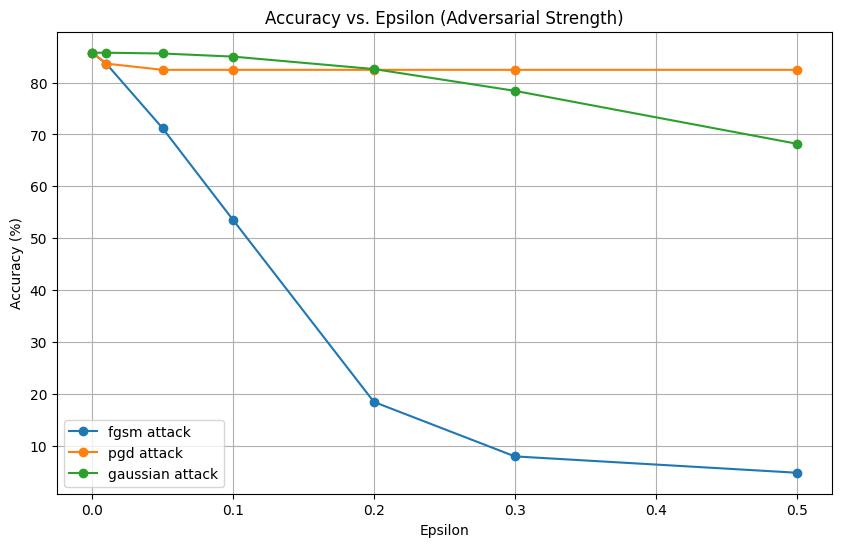

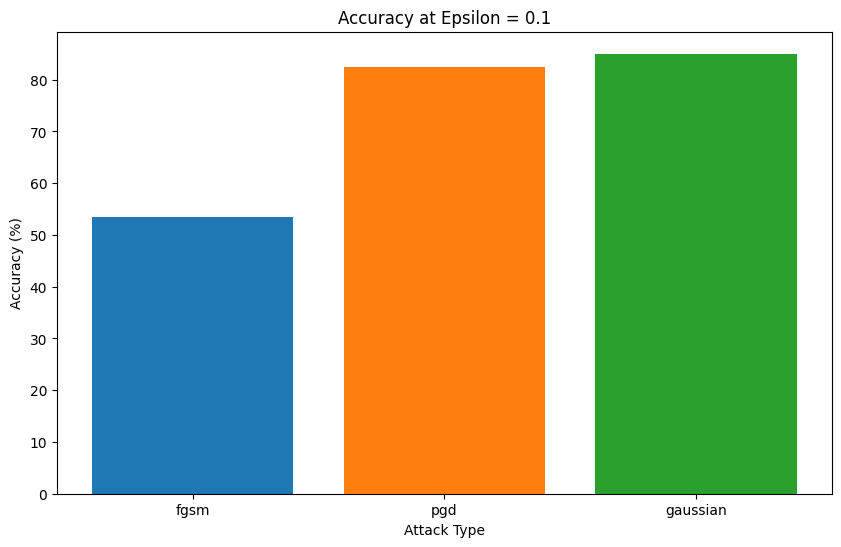

In [18]:
attacks = ['fgsm', 'pgd', 'gaussian']
epsilon_values = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
accuracies = {attack: [] for attack in attacks}

for attack in attacks:
    for epsilon in epsilon_values:
        accuracy = evaluate_under_attack(model, testloader, epsilon, attack_name=attack)
        accuracies[attack].append(accuracy)

# Plot the results as bar charts and line plots
plt.figure(figsize=(10, 6))
for attack, acc in accuracies.items():
    plt.plot(epsilon_values, acc, label=f'{attack} attack', marker='o')

# Add titles and labels
plt.title('Accuracy vs. Epsilon (Adversarial Strength)')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Bar plot for a specific epsilon (e.g., epsilon=0.1)
epsilon_idx = 3  # corresponding to epsilon=0.1
plt.figure(figsize=(10, 6))
for attack in attacks:
    plt.bar(attack, accuracies[attack][epsilon_idx])

plt.title(f'Accuracy at Epsilon = {epsilon_values[epsilon_idx]}')
plt.xlabel('Attack Type')
plt.ylabel('Accuracy (%)')
plt.show()
